In [58]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from skimage.feature import hog
from scipy.ndimage.measurements import label
from collections import deque
from utils.lesson_functions import *

Your function returned a count of 8792  cars and 8968  non-cars
of size:  (64, 64, 3)  and data type: uint8


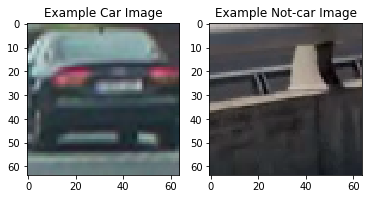

In [61]:
#Data information

notcar_list= glob.glob('../non-vehicles/*/*.png')
car_list = glob.glob('../vehicles/*/*.png')

data_info = data_look(car_list, notcar_list)

print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])
# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(car_list))
notcar_ind = np.random.randint(0, len(notcar_list))
    
# Read in car / not-car images
car_image = plt.imread(car_list[car_ind])
notcar_image = plt.imread(notcar_list[notcar_ind])

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')
plt.savefig('examples/car_not_car1.png',format='png')
plt.show()

6272


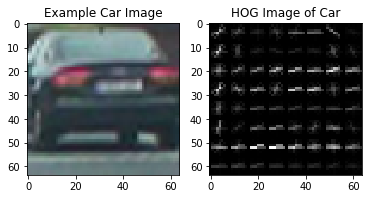

In [62]:
#HOG features of car

plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
features, hog_image = get_hog_features(car_image[:,:,0], orient=32, pix_per_cell=8, cell_per_block=2, vis=True, feature_vec=True)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Image of Car')
print(len(features))
plt.savefig('examples/HOG_example1.png',format='png')
plt.show()

In [63]:
#Model Training for vehicle detection

# FEATURE EXTRACTION
cspace='RGB'  # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
spatial_size=(32, 32)
hist_bins=32
orient=32
pix_per_cell=8
cell_per_block=2
hog_channel='ALL'  # Can be 0, 1, 2, or "ALL"
spatial_feat=True
hist_feat=True
hog_feat=True

t=time.time()
car_features = extract_features(car_list, cspace=cspace, spatial_size=spatial_size,
                                hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell,
                                cell_per_block=cell_per_block, hog_channel=hog_channel,
                                spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

notcar_features = extract_features(notcar_list, cspace=cspace, spatial_size=spatial_size,
                                   hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell,
                                   cell_per_block=cell_per_block, hog_channel=hog_channel,
                                   spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

#FEATURE NORMALIZATION
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

#SPLIT TRAIN_TEST DATA
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

print('Feature vector length:', len(X_train[0]))

128.01 Seconds to extract HOG features...
Feature vector length: 21984


# Training Model

In [64]:
from sklearn.svm import LinearSVC

# Use a linear SVC 
svc = LinearSVC()

# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()

print(round(t2-t, 2), 'Seconds to train SVC...')

285.07 Seconds to train SVC...


In [65]:
# Check the score of the SVC
print('Test Accuracy of Linear SVC Classifier = ', round(svc.score(X_test, y_test), 4))

# Check the prediction time for a single sample
t=time.time()
n_predict = 15

print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC') 

Test Accuracy of Linear SVC Classifier =  0.9859
My SVC predicts:  [ 0.  1.  0.  0.  0.  1.  1.  1.  1.  0.  1.  0.  1.  0.  1.]
For these 15 labels:  [ 0.  1.  0.  0.  0.  1.  1.  1.  1.  0.  1.  0.  1.  0.  1.]
0.01995 Seconds to predict 15 labels with SVC


In [66]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, xstart, cspace, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    #print("In find_cars function.. \n")
    box_list = []
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    # apply color conversion
#     if cspace == 'HSV':
#         img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
#     elif cspace == 'LUV':
#         img = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
#     elif cspace == 'HLS':
#         img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
#     elif cspace == 'YUV':
#         img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
#     elif cspace == 'YCrCb':
#         img = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)

    img_tosearch = img[ystart:ystop,xstart:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    #Since the window search is constrained around the heatmap, the sizes need to be checked
    if(ctrans_tosearch.shape[0] <64 or ctrans_tosearch.shape[1]<64):
        print("FIND_CARS: ctrans_tosearch shape <64")
        
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            #print("test_prediction value:", (test_prediction))
            if test_prediction == 1:
                xbox_left = xstart + np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
#                 print("test_prediction TRUE")
                box_list.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw, ytop_draw+win_draw+ystart)))
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
#     plt.imshow(draw_img)    
#     plt.show()
    return box_list, draw_img

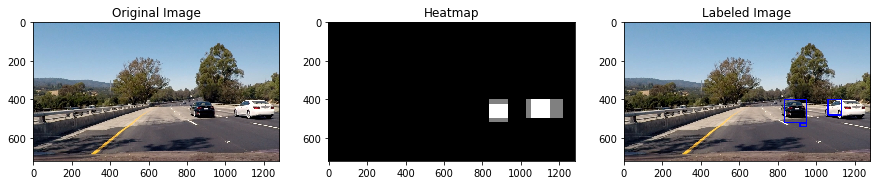

In [67]:
img = mpimg.imread('test_images/test4.jpg')
# img= cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
scale = 1.5
ystart = 400
ystop = 656
xstart = 500
threshold = 3
veh_detector = VehicleDetector()

out = veh_detector.pipeline(img)
plt.figure(figsize=(15,40))

#input image
plt.subplot(131)
plt.imshow(img)
plt.title('Original Image')

#heatmap
box_list, img_out = find_cars(img, ystart, ystop, xstart, cspace, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
veh_detector.update_heatmap(img, box_list, threshold)
plt.subplot(132)
plt.imshow(veh_detector.heatmap_count[1], cmap = 'gray')
plt.title('Heatmap')


#Label detection
plt.subplot(133)
labels = label(veh_detector.heatmap)
labeled_img = np.copy(img)
labeled_image = veh_detector.draw_labeled_bboxes(labeled_img, labels)
plt.imshow(labeled_image)
plt.title('Labeled Image')
plt.savefig('sliding_windows_hm_test4.png',format='png')
plt.show()

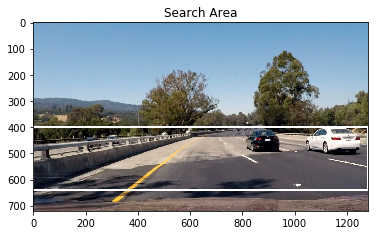

In [68]:
search_img=((0,400),(1280,640))
rect=np.copy(img)
plt.imshow(cv2.rectangle(rect,search_img[0],search_img[1], color=(255,255,255),thickness=5))
plt.title('Search Area')
plt.savefig('examples/sliding_windows.png',format='png')
plt.show()

In [ ]:
#storing the model and parameters

import pickle

model_data ={'svc': svc,'X_scaler': X_scaler,
    'cspace': cspace,
    'orient': orient,
    'pix_per_cell': pix_per_cell,
    'cell_per_block': cell_per_block,
    'spatial_size' : spatial_size,
    'hist_bins': hist_bins,
    'hog_channel': hog_channel
     }

with open('models/model-vd_RGB.pk', 'wb') as pFile:
    pickle.dump(model_data, pFile)

In [69]:
box_list

[((836, 400), (932, 496)),
 ((836, 424), (932, 520)),
 ((1028, 400), (1124, 496)),
 ((1052, 400), (1148, 496)),
 ((1124, 400), (1220, 496))]

# Vehicle Detection and Tracking Pipeline:

In [42]:
class VehicleDetector():
    def __init__(self):
        #current frame count
        self.frame_count = 0
        self.heatmap = None
        self.ystart = 400
        self.ystop = 660
        # Threshold of heat map
        self.threshold = 9
        self.threshold_smooth =6 
        # Heatmap count for the last three frames
        self.heatmap_count = deque(maxlen=5)
        # different scales 
        self.ystart_stop_scale = [(360, 560, 1.3), (400, 656, 1.5), (400, 656, 1.8), (400, 700, 2.5), (400, 700, 2.9)]
        self.scales = [1.2, 1.5, 1.8, 2.3, 2.9]
        self.xstart = 630
        # number of frames to be accounted at once
        self.time_filtering = 9
        self.kernel = np.ones((200,200))
        self.bbox_total = [0,0,0,0,0,0,0,0,0]
        
    def update_heatmap(self, draw_img, bbox_list, threshold):
#         if self.heatmap == None:
        self.heatmap = np.zeros_like(draw_img[:,:,0]).astype(np.float)
        for box in bbox_list:
            # Add += 1 for all pixels inside each bbox
            # Assuming each "box" takes the form ((x1, y1), (x2, y2))
            self.heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] +=1
        
        self.heatmap_count.append(self.heatmap)
        self.heatmap = np.sum(np.array(self.heatmap_count), axis=0)
        self.heatmap[self.heatmap <= threshold] = 0
    
    def draw_labeled_bboxes(self, img, labels):
        # Iterate through all detected cars
        bbox_label_car = []
        for car_number in range(1, labels[1]+1):
            # Find pixels with each car_number label value
            nonzero = (labels[0] == car_number).nonzero()
            # Identify x and y values of those pixels
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            # Define a bounding box based on min/max x and y
            bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
            # Draw the box on the image
            cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
            #bbox_label_car.extend(bbox)
            bbox_label_car.append(((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy))))

        # Return the image
        return img, bbox_label_car
    
    def pipeline(self, img):
        
        draw_img = np.copy(img)
        box_list_tot = []
        
        #filter for upto 10 frames
        counter = self.frame_count % self.time_filtering
        self.frame_count +=1
        # For each frame, calc boxes for all the different scales
        for scale in self.scales:      
            box_list, img_out = find_cars(img, self.ystart, self.ystop, self.xstart, cspace, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
            box_list_tot.extend(box_list)
        
        # add heatmap for each box list
        self.update_heatmap(draw_img, box_list_tot, self.threshold)
        # find total boxes using label function
        labels = label(self.heatmap)
        temp_img, bbox_label_car = self.draw_labeled_bboxes(draw_img, labels)
        
        
        self.bbox_total[counter] = bbox_label_car
        
        # Average over the time filter of ten frames
        box_car = []
        for box_t in self.bbox_total:
            if box_t!=0:
                for i in box_t:
                    box_car.append(i)
        #print("box_car:", box_car)
        # add heatmap for each box list over 10 frames
        self.update_heatmap(draw_img, box_car, self.threshold_smooth)
        # find total boxes using label function
        labels = label(self.heatmap)
        final_img, bbox_label_car_fin = self.draw_labeled_bboxes(draw_img, labels)
               
        
        #return final_img, self.heatmap
        return final_img

In [ ]:
# Test on video
from moviepy.editor import VideoFileClip
from IPython.display import HTML

vehicle_detector = VehicleDetector()

clip1 = VideoFileClip("project_video.mp4")
# clip1 = clip1.subclip(t_start=0.0, t_end=35.0)
out_clip = clip1.fl_image(vehicle_detector.pipeline) #NOTE: this function expects color images!!
out_file = "project_video_out.mp4"
%time out_clip.write_videofile(out_file, audio=False)

[MoviePy] >>>> Building video submission_out5_fin.mp4
[MoviePy] Writing video submission_out5_fin.mp4



100%|█████████▉| 1256/1261 [10:50<00:02,  1.91it/s]

In [ ]:
# Test pipeline on test images
test_image_files = glob.glob('test_images/*.jpg')
for image_file in test_image_files:
    image = mpimg.imread(image_file)
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    draw_img = np.copy(image)
    vehicle_detector = VehicleDetector()
    
    final_img = vehicle_detector.pipeline(image)

    fig = plt.figure(figsize=(20,20))
    plt.subplot(131)
    plt.imshow(image)
    plt.title('Original image')
    plt.subplot(132)
    plt.imshow(final_img)
    plt.title('Car detections')
#     plt.subplot(133)
#     plt.imshow(heatmap, cmap='hot')
#     plt.title('Heat Map')
    fig.tight_layout()
    plt.savefig('examples/sliding_window_test.png',format='png')
    plt.show()

In [ ]:
# class VehicleDetector():
#     def __init__(self):
#         #current frame count
#         self.frame_count = 0
#         self.heatmap = None
#         self.ystart = 400
#         self.ystop = 656
#         # Threshold of heat map
#         self.threshold = 4
#         # Heatmap count for the last three frames
#         self.heatmap_count = deque(maxlen=4)
#         # different scales 
#         self.ystart_stop_scale = [(360, 560, 1.4), (400, 656, 1.5), (400, 620, 1.9), (420, 700, 2.5), (440, 700, 3)]
#         self.scales = np.linspace(1.3, 2.7, num=7, endpoint=True)
#         self.xstart = 600
#         # number of frames to be accounted at once
#         self.time_filtering = 8
#         self.kernel = np.ones((400,400))
        
#     def update_heatmap(self, draw_img, bbox_list, threshold):
# #         if self.heatmap == None:
#         self.heatmap = np.zeros_like(draw_img[:,:,0]).astype(np.float)
#         for box in bbox_list:
#             # Add += 1 for all pixels inside each bbox
#             # Assuming each "box" takes the form ((x1, y1), (x2, y2))
#             self.heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] +=1
        
#         self.heatmap_count.append(self.heatmap)
#         self.heatmap = np.sum(np.array(self.heatmap_count), axis=0)
#         self.heatmap[self.heatmap <= threshold] = 0
    
#     def draw_labeled_bboxes(self, img, labels):
#         # Iterate through all detected cars
#         for car_number in range(1, labels[1]+1):
#             # Find pixels with each car_number label value
#             nonzero = (labels[0] == car_number).nonzero()
#             # Identify x and y values of those pixels
#             nonzeroy = np.array(nonzero[0])
#             nonzerox = np.array(nonzero[1])
#             # Define a bounding box based on min/max x and y
#             bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
#             # Draw the box on the image
#             cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
#         # Return the image
#         return img
    
#     def pipeline(self, img):
        
# #         X_scaler = self.X_scaler
# #         orient = self.orient
# #         pix_per_cell = self.pix_per_cell
# #         cell_per_block = self.cell_per_block
# #         spatial_size = self.spatial_size
# #         hist_bins = self.hist_bins
# #         svc = self.svc
        
#         draw_img = np.copy(img)
#         img = img.astype(np.float32) / 255
#         box_list = []
        
#         #filter for upto 10 frames
#         if self.frame_count % self.time_filtering == 0:
#             img_mask = np.ones_like(img[:,:,0])
#         else:
#             img_mask = np.sum(np.array(self.heatmap_count), axis=0)
#             img_mask[(img_mask >0)] = 1
#             img_mask = cv2.dilate(img_mask, self.kernel, iterations = 1)
        
#         for (self.ystart, self.ystop, scale) in self.ystart_stop_scale:
#         #for scale in self.scales:
#             nonzero = img_mask.nonzero()
#             nonzeroy = np.array(nonzero[0])
#             nonzerox = np.array(nonzero[1])
        
#             if len(nonzeroy)!= 0:
#                 self.ystart = max(np.min(nonzeroy),self.ystart)
#                 self.ystop = min(np.max(nonzeroy), self.ystop)
#             if len(nonzerox) !=0:
#                 self.xstart = max(np.min(nonzerox), self.xstart)
#                 xstop = np.max(nonzerox)
#             else:
#                 continue
                
#             if xstop<= self.xstart or self.ystop<= self.ystart:
#                 continue
            
#             img_tosearch = img[self.ystart:self.ystop,self.xstart:,:]
#             ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')

#             if scale != 1:
#                 imshape = ctrans_tosearch.shape
#                 ysize = np.int(imshape[1] / scale)
#                 xsize = np.int(imshape[0] / scale)
#                 if (ysize < 1 or xsize < 1):
#                     continue
#                 ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

#             #Since the window search is constrained around the heatmap, the sizes need to be checked
#             if(ctrans_tosearch.shape[0] <64 or ctrans_tosearch.shape[1]<64):
#                 continue

#             ch1 = ctrans_tosearch[:,:,0]
#             ch2 = ctrans_tosearch[:,:,1]
#             ch3 = ctrans_tosearch[:,:,2]

#             # Define blocks and steps as above
#             nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
#             nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
#             nfeat_per_block = orient*cell_per_block**2

#             # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
#             window = 64
#             nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
#             cells_per_step = 2  # Instead of overlap, define how many cells to step
#             nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
#             nysteps = (nyblocks - nblocks_per_window) // cells_per_step

#             # Compute individual channel HOG features for the entire image
#             hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
#             hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
#             hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

#             for xb in range(nxsteps):
#                 for yb in range(nysteps):
#                     ypos = yb*cells_per_step
#                     xpos = xb*cells_per_step
#                     # Extract HOG for this patch
#                     hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
#                     hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
#                     hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
#                     hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

#                     xleft = xpos*pix_per_cell
#                     ytop = ypos*pix_per_cell

#                     # Extract the image patch
#                     #subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
#                     subimg = ctrans_tosearch[ytop:ytop+window, xleft:xleft+window]

#                     # Get color features
#                     spatial_features = bin_spatial(subimg, size=spatial_size)
#                     hist_features = color_hist(subimg, nbins=hist_bins)

#                     # Scale features and make a prediction
#                     test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
#                     #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
#                     test_prediction = svc.predict(test_features)
#                     if test_prediction == 1:
#                         xbox_left = self.xstart + np.int(xleft*scale)
#                         ytop_draw = np.int(ytop*scale)
#                         win_draw = np.int(window*scale)
#                         box_list.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw, ytop_draw+win_draw+ystart)))

#         # add heatmap for each box list
#         self.update_heatmap(draw_img, box_list, self.threshold)
    
#         # find total boxes using label function
#         labels = label(self.heatmap)
#         final_img = self.draw_labeled_bboxes(draw_img, labels)
        
#         self.frame_count +=1
#         #return final_img, self.heatmap
#         return final_img